In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_absolute_error
tf.logging.set_verbosity(tf.logging.ERROR)
RANDOM_SEED = 39
tf.set_random_seed(RANDOM_SEED)

In [2]:
#Correspond to selected indices in get_features_methods
features = [
    'precipitation_amt_mm'
    'reanalysis_specific_humidity_g_per_kg', 
    'reanalysis_dew_point_temp_k', 
    'station_avg_temp_c', 
    'reanalysis_min_air_temp_k',
    'reanalysis_tdtr_k',
]

def get_features_sj():
    train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2])

    train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

    sj_train_features = train_features.loc['sj']
    sj_train_labels = train_labels.loc['sj']

    sj_train_features.drop('week_start_date', axis=1, inplace=True)
    sj_train_features.fillna(method='ffill', inplace=True)

    sj_train_features = sj_train_features.as_matrix()[:,[4, 7, 10, 11, 15, 16, 19]]
    sj_train_labels = sj_train_labels.as_matrix()

    return sj_train_features, sj_train_labels

def get_features_iq():
    train_features = pd.read_csv('dengue_features_train.csv',
                             index_col=[0,1,2])

    train_labels = pd.read_csv('dengue_labels_train.csv',
                           index_col=[0,1,2])

    iq_train_features = train_features.loc['iq']
    iq_train_labels = train_labels.loc['iq']

    iq_train_features.drop('week_start_date', axis=1, inplace=True)
    iq_train_features.fillna(method='ffill', inplace=True)

    iq_train_features = iq_train_features.as_matrix()[:, [4, 7, 10, 11, 15, 16, 19]]
    iq_train_labels = iq_train_labels.as_matrix()
    
    return iq_train_features, iq_train_labels

In [3]:
def get_data_sj():
    
    sj_train_features, sj_train_labels = get_features_sj()
    return train_test_split(sj_train_features, sj_train_labels, test_size=0.1, random_state=RANDOM_SEED)

def get_data_iq():
    
    iq_train_features, iq_train_labels = get_features_iq()
    return train_test_split(iq_train_features, iq_train_labels, test_size=0.1, random_state=RANDOM_SEED)

In [4]:
#SJ data
train_X, test_X, train_y, test_y = get_data_sj()

#IQ data
train_X2, test_X2, train_y2, test_y2 = get_data_iq()

/Users/ericweltz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ericweltz/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Users/ericweltz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(train_X)
feature_columns2 = tf.contrib.learn.infer_real_valued_columns_from_input(train_X2)


# SJ model
classifier = tf.contrib.learn.DNNRegressor(feature_columns=feature_columns,
                                           hidden_units=[128, 64, 32], 
                                           optimizer=tf.train.ProximalAdagradOptimizer(
                                               learning_rate=0.1,
                                               l2_regularization_strength=0.001),
                                          )

#IQ model                                   
classifier2 = tf.contrib.learn.DNNRegressor(feature_columns=feature_columns2,
                                           hidden_units=[300, 200, 100],
                                           optimizer=tf.train.ProximalAdagradOptimizer(
                                               learning_rate=0.1,
                                               l2_regularization_strength=0.001),  
                                           )

In [6]:
# Fit and predict.
classifier.fit(train_X, train_y, steps=2000)
classifier2.fit(train_X2, train_y2, steps=200)

/Users/ericweltz/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x1196fe9e8>, 'hidden_units': [300, 200, 100], 'feature_columns': (_RealValuedColumn(column_name='', dimension=7, default_value=None, dtype=tf.float64, normalizer=None),), 'optimizer': <tensorflow.python.training.proximal_adagrad.ProximalAdagradOptimizer object at 0x116def4e0>, 'activation_fn': <function relu at 0x111e14488>, 'dropout': None, 'gradient_clip_norm': None, 'embedding_lr_multipliers': None, 'input_layer_min_slice_size': None})

In [7]:
# Predict and print error
predictions = list(classifier.predict(test_X, as_iterable=True))
score = metrics.mean_absolute_error(test_y, predictions)
print('Accuracy SJ: {0:f}'.format(score))
predictions2 = list(classifier2.predict(test_X2, as_iterable=True))
score2 = metrics.mean_absolute_error(test_y2, predictions2)
print('Accuracy IQ: {0:f}'.format(score2))

/Users/ericweltz/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py:248: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


Accuracy SJ: 22.558536
Accuracy IQ: 6.108762


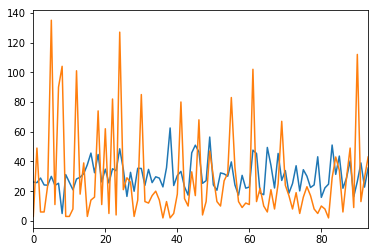

In [8]:
#SJ test graph
from pandas import Series
from matplotlib import pyplot
series = Series.from_array(predictions)
series2 = Series.from_array(np.squeeze(test_y))
series.plot()
series2.plot()
pyplot.show()

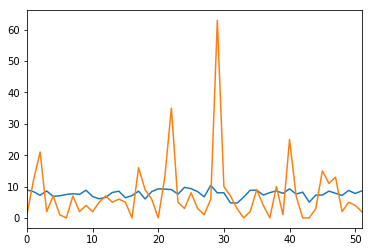

In [9]:
#IQ test graph
series3 = Series.from_array(predictions2)
series4 = Series.from_array(np.squeeze(test_y2))
series3.plot()
series4.plot()
pyplot.show()

In [10]:
# Get test features and predict
test_features = pd.read_csv('dengue_features_test.csv',
                             index_col=[0,1,2])

sj_test_features = test_features.loc['sj']

iq_test_features = test_features.loc['iq']

sj_test_features.drop('week_start_date', axis=1, inplace=True)
iq_test_features.drop('week_start_date', axis=1, inplace=True)

sj_test_features.fillna(method='ffill', inplace=True)
iq_test_features.fillna(method='ffill', inplace=True)


sj_test_features = sj_test_features.as_matrix()[:, [4, 7, 10, 11, 15, 16, 19]]
iq_test_features = iq_test_features.as_matrix()[:, [4, 7, 10, 11, 15, 16, 19]]

sj_predictions = list(classifier.predict(sj_test_features, as_iterable=True))
iq_predictions = list(classifier2.predict(iq_test_features, as_iterable=True))

sj_predictions = [int(round(guess)) for guess in sj_predictions]
iq_predictions = [int(round(guess)) for guess in iq_predictions]

submission = pd.read_csv('submission_format.csv', index_col=[0, 1, 2])
submission.total_cases = np.concatenate([sj_predictions, iq_predictions])
submission.to_csv('answersv1.csv')

/Users/ericweltz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ericweltz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/ericweltz/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:2842: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)
/Users/ericweltz/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprec

In [ ]:
num_epochs = 30
truncated_backprop_length = 8
state_size = 20
num_classes = 1
batch_size = 1


In [ ]:
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.float32, [truncated_backprop_length, 1])

In [ ]:
init_state = tf.placeholder(tf.float32, [1, state_size])

In [ ]:
inputs_series = tf.split(batchX_placeholder, truncated_backprop_length, 1)

In [ ]:
cell = tf.contrib.rnn.core_rnn_cell.BasicRNNCell(state_size)

In [ ]:
with tf.variable_scope('rnn'):
    states_series, current_state = tf.contrib.rnn.static_rnn(cell, inputs_series, init_state)

In [ ]:
W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

In [ ]:
logits_series = [tf.matmul(state, W2) + b2 for state in states_series]

In [ ]:
labels_series = tf.unstack(batchY_placeholder, axis=1)

In [ ]:
losses = [tf.contrib.losses.mean_squared_error(predictions=tf.squeeze(logits), labels=labels) for logits, 
          labels in zip([tf.unstack(logits_series)], labels_series)]
total_loss = tf.reduce_mean(losses)

In [ ]:
train_step = tf.train.AdagradOptimizer(0.01).minimize(total_loss)

predictions_series = [tf.matmul(batchX_placeholder, tf.squeeze(logits_series, 1))]

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    loss_list = []

    for epoch_idx in range(num_epochs):
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)

        for batch_idx in range(750//truncated_backprop_length - batch_size):
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = [sj_predictions[start_idx:end_idx]]
            batchY = train_y[start_idx:end_idx, :]

            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%10 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
